In [1]:
# imports
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import time
import networkx as nx
from tqdm import tqdm
import pickle
import random

In [2]:
# constants
budget = 40

In [3]:
# In: graph, the set of seed nodes, spread probability, Monte-Carlo simulations --> Out: marginal gain

def IC(g,S,p=0.5,mc=1000):

    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:

                node_dict = dict(g[node])
                node_neighbours = list(node_dict.keys())
                
                global node_weights_globaldict
                weights_list = node_weights_globaldict[node]
                weights_np = np.array(weights_list) 

                # Determine neighbors that become infected
                np.random.seed((int)(node)+i)                
                success = (np.random.uniform(0,1,len(g[node]))+weights_np) > p
                new_ones += list(np.extract(success, node_neighbours))

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
            
        spread.append(len(A))
        
    return(np.mean(spread))

In [4]:
# In: graph, #nodes in the set of seed nodes, spread probability, Monte-Carlo simulations, cost dictionary and budget --> Out: set of seed nodes, reward and time

def greedy(g,k,p=0.1,mc=1000,node_cost_dict={}, budget=budget):

    S, spread, timelapse, start_time = [], [], [], time.time()
    
    # Find k nodes with largest marginal gain
    for _ in tqdm(range(k)):
        node = None

        # Loop over nodes that are not yet in seed set to find biggest marginal gain
        best_spread = 0
        # for j in set(range(len(g.nodes)))-set(S):
        for j in set(g.nodes)-set(S):

            if node_cost_dict[j]<=budget:
                # Get the spread
                s = IC(g,S + [j],p,mc)/node_cost_dict[j]

                # Update the winning node and spread so far
                if s > best_spread:
                    best_spread, node = s, j
                    
        if node != None:
            # Add the selected node to the seed set
            S.append(node)
            budget = budget - node_cost_dict[node]

            print('**GREEDY HERE** - picked up node:',node)
            
            # Add estimated spread and elapsed time
            spread.append(best_spread)
            timelapse.append(time.time() - start_time)

    return(S,spread,timelapse)

In [3]:
# In: graph, #nodes in the set of seed nodes, dimeter of detection, Monte-Carlo simulations --> Out: set of seed nodes, reward and time

def detection_time(g,k,d=10,mc=1000):

    nodes_latency_dict = dict()

    for root in tqdm(set(g.nodes)):
        for i in range(mc):
            random.seed((int)(root+i))

            previous_node = root
            next_node = root
            latency_list = list()
            current_depth = 1
            latency = 0
            while current_depth<=d:
                node_dict = dict(g[previous_node])
                node_neighbours = list(node_dict.keys())
                next_node = random.choice(node_neighbours)

                key = (previous_node,next_node)
                global edge_latency_dict
                latency += edge_latency_dict[key]

                previous_node = next_node
                current_depth+=1
            
            latency_list.append(latency)
            
        nodes_latency_dict[root] = np.mean(latency_list)

    return(nodes_latency_dict)

In [6]:
# In: graph, #nodes in the set of seed nodes, spread probability, Monte-Carlo simulations, cost dictionary and budget --> Out: set of seed nodes, reward and time

def celf(g,k,p=0.1,mc=1000,node_cost_dict={}, budget=budget):  
    
    start_time = time.time() 
    marg_gain = []
    for node in g.nodes:
        marg_gain.append(IC(g,[node],p,mc)/node_cost_dict[node])

    Q = sorted(zip(g.nodes,marg_gain), key=lambda x: x[1],reverse=True)

    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [len(g.nodes)], [time.time()-start_time]
    budget = budget - node_cost_dict[Q[0][0]]
    
    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------

    for _ in tqdm(range(k-1)):    

        check, node_lookup = False, 0

        # Shorten the candidate list based on whether the cost of a node is less or equal to our budget
        j=0
        while j < len(Q):
            if node_cost_dict[Q[j][0]] > budget:
                Q.pop(j)
                j = j-1
            j = j+1
        
        if Q:
            while not check:
                
                # Count the number of times the spread is computed
                node_lookup += 1
                
                # Recalculate spread of top node
                current = Q[0][0]
                
                # Evaluate the spread function and store the marginal gain in the list
                marg_gain = (IC(g,S+[current],p,mc)/node_cost_dict[current]) - spread
                Q[0] = (current,marg_gain)

                # Re-sort the list
                Q = sorted(Q, key = lambda x: x[1], reverse = True)

                # Check if previous top node stayed on top after the sort
                check = (Q[0][0] == current)

            # Select the next node
            spread += Q[0][1]
            S.append(Q[0][0])
            budget = budget - node_cost_dict[Q[0][0]]
            SPREAD.append(spread)
            LOOKUPS.append(node_lookup)
            timelapse.append(time.time() - start_time)

            # Remove the selected node from the list
            Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)

In [4]:
big_file = r'bigfile.txt'
small_file = r'smallfile.txt'

filehandler = open(small_file, 'r',encoding='utf-8')
Lines = filehandler.readlines()

In [5]:
# parameter weight_flag
weight_flag = False

edge_list = list()
for line in Lines:
    # if you use big_file then below line should be: tokens = line.strip().split('\t')
    tokens = line.strip().split(' ')
    node1 = (int)(tokens[0])-1
    node2 = (int)(tokens[1])-1
    if (weight_flag):
        weight = (float)(tokens[2])
        edge = (node1,node2,weight)
    else:
        edge = (node1,node2)
    edge_list.append(edge)

In [6]:
# construct the network
g = nx.Graph()
g.add_edges_from(edge_list)

# COSTS 
- (DEFAULT) costs = 1 for unit-cost algorithms
- (UNCOMMENT the comments) costs based on conditions for cost-sensitive algorithms

In [7]:
# cost_list = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]
# node_cost_dict = dict()
# for i in g.nodes:
#     if g.degree(i)>=40:
#         node_cost_dict[i] =  1.9
#     elif g.degree(i)>=35 and g.degree(i)<40:
#         node_cost_dict[i] = 1.8
#     elif g.degree(i)>=30 and g.degree(i)<35:
#         node_cost_dict[i] = 1.7
#     elif g.degree(i)>=25 and g.degree(i)<30:
#         node_cost_dict[i] = 1.6
#     elif g.degree(i)>=20 and g.degree(i)<25:
#         node_cost_dict[i] = 1.5
#     elif g.degree(i)>=15 and g.degree(i)<20:
#         node_cost_dict[i] = 1.4
#     elif g.degree(i)>=10 and g.degree(i)<15:
#         node_cost_dict[i] = 1.3
#     elif g.degree(i)>=5 and g.degree(i)<10:
#         node_cost_dict[i] = 1.2
#     elif g.degree(i)>=2 and g.degree(i)<5:
#         node_cost_dict[i] = 1.15
#     else:
#         node_cost_dict[i] = 1.1
node_cost_dict = dict()
for i in g.nodes:
    node_cost_dict[i] = 1

# WEIGHTS
- (DEFAULT) weights = [0, 0, 0, 0, 0] for non-weight-sensitive algorithms
- (UNCOMMENT the comments) weights = [-0.2, -0.1, 0, 0.1, 0.2] for weight-sensitive algorithms

In [8]:
random.seed(11)
node_neighweights_globaldict = dict()
# weights = [-0.2, -0.1, 0, 0.1, 0.2]
weights = [0, 0, 0, 0, 0]
for current_node in g.nodes:
    neighbours_weight_dict = dict()

    tmp_dict = dict(g[current_node])
    neighbours = list(tmp_dict.keys())

    for neighbour in neighbours:
        if neighbour in node_neighweights_globaldict.keys():
            num = node_neighweights_globaldict[neighbour][current_node]
        else:
            num = random.choice(weights)
        neighbours_weight_dict[neighbour] = num

    node_neighweights_globaldict[current_node] = neighbours_weight_dict

In [9]:
node_weights_globaldict = dict()
for k,v in node_neighweights_globaldict.items():
    node_weights_globaldict[k] = list(v.values())

# TIMESTAMPS
by default the objective function is population affected (uncomment the comments to change the objective function to the detetion time)

In [10]:
# random.seed(11)
# edge_latency_dict = dict()
# latencies = [x+1 for x in range(20)]
# for current_edge in g.edges:
#     edge_latency_dict[current_edge] = random.choice(latencies)

#     reverse_edge = (current_edge[1], current_edge[0])
#     edge_latency_dict[reverse_edge] = edge_latency_dict[current_edge]

# output = detection_time(g,10,d = 20, mc = 1000)
# output_top_nodes = dict()
# for _ in range(10):
#     Keymax = max(zip(output.values(), output.keys()))[1]
#     Valuemax = max(zip(output.values(), output.keys()))[0]
#     output_top_nodes[Keymax] = Valuemax
#     output.pop(Keymax)

# RUN

In [13]:
celf_output   = celf(g,10,p = 0.5,mc = 100, node_cost_dict=node_cost_dict, budget=budget)
print("celf output:   " + str(celf_output[0]))

# save results
# output_dict = dict()
# output_dict['celf_output'] = celf_output
# output_file = 'small_celf_costs.pickle'
# with open(output_file, 'wb') as handle:
#     pickle.dump(output_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 9/9 [11:27<00:00, 76.34s/it]   

celf output:   [138, 118, 78, 397, 389, 369, 134, 312, 21, 185]


In [14]:
placement = [138, 118, 78, 397, 389, 369, 134, 312, 21, 185]
betweenness_centrality = nx.betweenness_centrality(g)
degree_centrality = nx.degree_centrality(g)

# find average betweenness centrality of the nodes in the network

avg_betweenness_centrality = 0
for i in betweenness_centrality:
    avg_betweenness_centrality += betweenness_centrality[i]
avg_betweenness_centrality = avg_betweenness_centrality/len(betweenness_centrality)
print(avg_betweenness_centrality)

# find max betweeness centrality of the nodes in the network

max_betweenness_centrality = 0
for i in betweenness_centrality:
    if betweenness_centrality[i] > max_betweenness_centrality:
        max_betweenness_centrality = betweenness_centrality[i]
print(max_betweenness_centrality)

0.006448172924128206
0.2652804824685363


In [ ]:
greedy_output = greedy(g,10,p = 0.5,mc = 1, node_cost_dict=node_cost_dict, budget=budget)
print("greedy output: " + str(greedy_output[0]))

# save results
# output_dict = dict()
# output_dict['greedy_output'] = greedy_output
# output_file = 'small_greedy_costs.pickle'
# with open(output_file, 'wb') as handle:
#     pickle.dump(output_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
def plot_CT(x, y_greedy, y_celf):
     
    # first plot with X and Y data
    plt.plot(x, y_greedy, linestyle='--', marker='o', color='r', label='GREEDY')
    
    # second plot with x1 and y1 data
    plt.plot(x, y_celf, linestyle='--', marker='o', color='b', label='CELF')
    
    plt.xlabel("Nodes selected")
    plt.ylabel("Time in seconds")
    plt.title('Computation time: CELF vs GREEDY')
    plt.legend()
    plt.show()

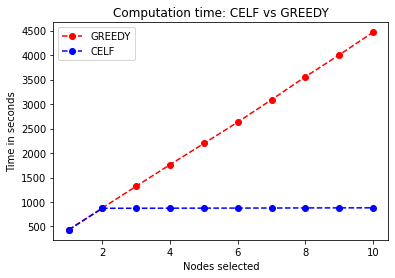

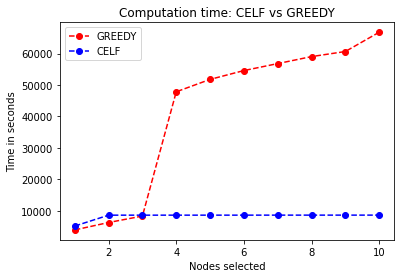

In [34]:
# plot time
x_axis = [1,2,3,4,5,6,7,8,9,10]
plot_CT(x_axis, greedy['greedy_output'][2], celf['celf_output'][2])
plot_CT(x_axis, greedy_big['greedy_output'][2], celf_big['celf_output'][2])